# TCC - Helder Rezende

In [1]:
import pandas as pd
from datetime import datetime
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
import requests
import pandas.io.data as web
import seaborn as sns
plt.style.use('ggplot')

%matplotlib inline

/home/helder/anaconda2/lib/python2.7/site-packages/pandas/io/data.py:35: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


## Pegando a cotação da Ibovespa de 2012 até a data atual

In [2]:
cotacoes = web.DataReader('^BVSP', data_source='yahoo', start='1/1/2000')['Close']

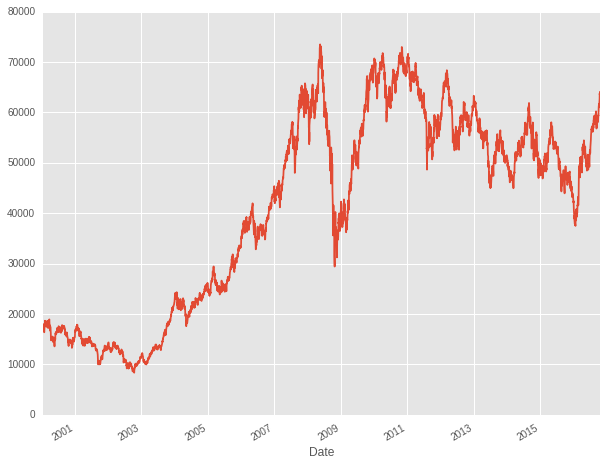

In [3]:
cotacoes[5:].plot(figsize = (10,8))
plt.savefig('cotacao_bovespa.png',bbox_inches='tight')

## Calculando os Retornos

In [4]:
retornos = (cotacoes / cotacoes.shift(1) -1)

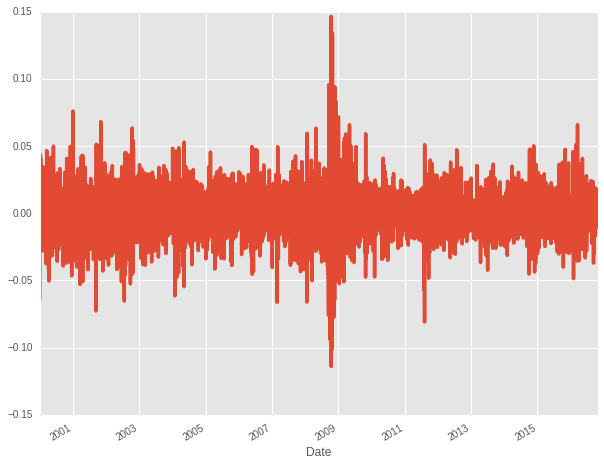

In [5]:
retornos.plot(figsize = (10,8),linewidth=3.5)

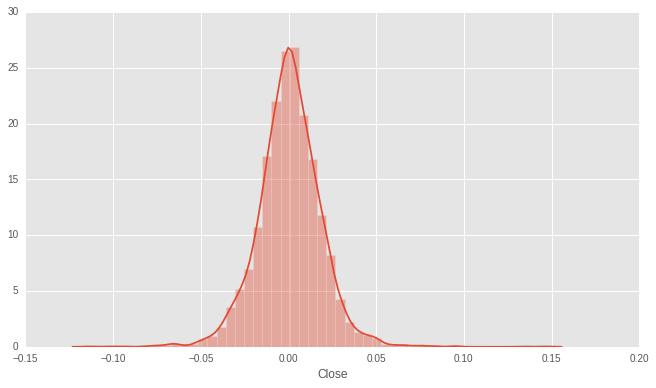

In [6]:
f, ax = plt.subplots(figsize=(11, 6))
sns.distplot(retornos.dropna())
plt.savefig('retornos_ambev.png',bbox_inches='tight')

## Calculando, por fim, a volalitidade ao longo do tempo.

In [7]:
volatilidade_valores = []
#retornos = pd.DataFrame(retornos)


In [8]:
volatilidade_valores = pd.rolling_std(retornos,30)*100*sqrt(252)
#for x in range(len(retornos)):
#    volatilidade_valores.append(pd.rolling_std(retornos[:x],30)*100*sqrt(252))


/home/helder/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=30,center=False).std()
  if __name__ == '__main__':


In [9]:
volatilidade = pd.DataFrame(volatilidade_valores, index = retornos.index,columns = ["Index IBOVESPA"])

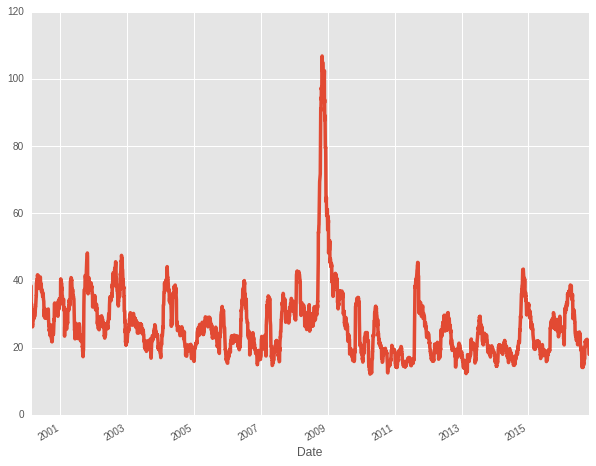

In [10]:
volatilidade_valores[30:].plot(figsize = (10,8),linewidth=3.5)
plt.savefig('volatilidade_bovespa.png',bbox_inches='tight')

### Using Extreme Value Theory and Copulas to Evaluate Market Risk



This example shows how to model the market risk of a hypothetical global equity index portfolio with a Monte Carlo simulation technique using a Student's t copula and Extreme Value Theory (EVT). The process first extracts the filtered residuals from each return series with an asymmetric GARCH model, then constructs the sample marginal cumulative distribution function (CDF) of each asset using a Gaussian kernel estimate for the interior and a generalized Pareto distribution (GPD) estimate for the upper and lower tails. A Student's t copula is then fit to the data and used to induce correlation between the simulated residuals of each asset. Finally, the simulation assesses the Value-at-Risk (VaR) of the hypothetical global equity portfolio over a one month horizon.

Note that this is a relatively advanced, comprehensive example that assumes some familiarity with EVT and copulas. For details regarding estimation of generalized Pareto distributions and copula simulation, see the Modelling Tail Data with the Generalized Pareto Distribution and Simulating Dependent Random Variables Using Copulas in the Statistics and Machine Learning Toolbox™. For details regarding the approach upon which most of this example is based, see references [5] and [6] by Nystrom and Skoglund in the bibliography.


In [69]:
iniditalDate = "1/1/2014"
ativos = ['ABEV3', 'PETR4','RADL3','BBDC4']

In [60]:
cotacoesAmbev = web.DataReader('ABEV3.SA', data_source='yahoo', start=iniditalDate)['Close']
cotacoesPetr = web.DataReader('PETR4.SA', data_source='yahoo', start=iniditalDate)['Close']
cotacoesRadl = web.DataReader('RADL3.SA', data_source='yahoo', start=iniditalDate)['Close']
cotacoesBbdc = web.DataReader('BBDC4.SA', data_source='yahoo', start=iniditalDate)['Close']


In [61]:
cotacoes = [cotacoesAmbev,cotacoesPetr,cotacoesRadl,cotacoesBbdc]
cotacoesPandas = pd.DataFrame(index = ativos, data = cotacoes)


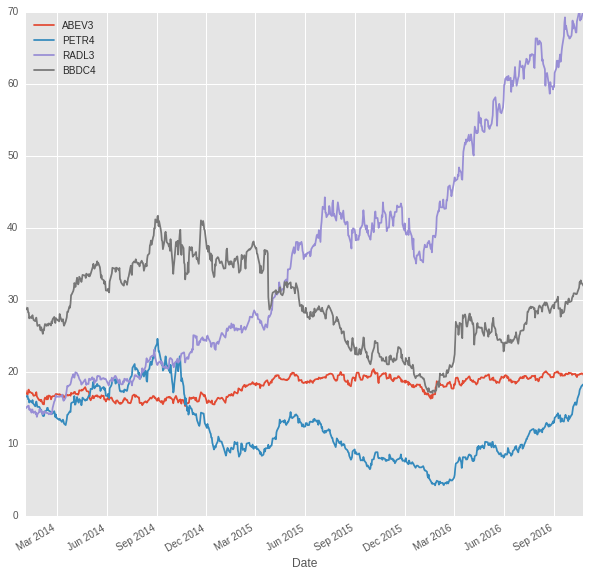

In [62]:
cotacoesPandas.transpose().dropna().plot(figsize= (10,10))

In [63]:
def logReturn(cotacoes):
    return np.log((cotacoes / cotacoes.shift(1)))[1:]

In [72]:
returns = [logReturn(cotacoes[x]) for x in range(len(cotacoes))]
returnsPandas = pd.DataFrame(index = ativos, data = returns)

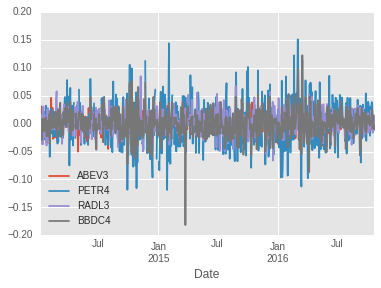

In [74]:
returnsPandas.transpose().plot()